In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from warnings import filterwarnings; filterwarnings('ignore')

In [2]:
train_df = pd.read_pickle('../data/train_df.p')

### One-Way Analysis of Variance (ANOVA)
ANOVA is a hypothesis test that tests if the mean of two populations are equal.  

It is helpful to see if a feature is related to the `SalePrice`. For example, ANOVA implies that `OverallQual` matters because of the difference in the sale prices of home of low quality and homes of high quality. It is implying that the mean price of a home of low quality is not equal to that of a home of high quality. You can see this in comparing the distributions of sale prices by feature.  

In order for One-Way ANOVA to be appropriate, our data needs to approximately follow the assumptions underlying One-Way ANOVA. We need only approximate because One-Way ANOVA is *robust* meaning that it is little affected by violation an assumption. The degree of robustnes requires a long discussion. For our sakes, it suffices to eyeball the data distributioons. The assumptions are  
1. **independence** The observations are random and independent samples from the population.  
2. **normality** The distributions of the populations are normal.
    - **Shapiro-Wilks test** is a hypothesis test testing the hypothesis that the sample data have been drawn from a normally distributed population. Note that it is very conservative and most statisticians (us) agree that it should not be the sole determination of normality. We can also use the following tools.
    - **Examine Skewness and Kurtosis** We can surely quantify skewness and kurtosis. We can also just eyeball the distribution. 
    - **Normal Q-Q Plots**  
    
3. **homogeneity of variance** The variances of the distributions in the populations are equal.  
    - **The Levene's F-Test for Equaity of Variances** This test is the most commonly used statistic to test the assumption of homoskedasticity. 

In [3]:
to_drop = list()

In [4]:
def my_anova(feature):
    feat_s = train_df[feature]
    sq_within = []
    
    for val in feat_s.unique():
        val_s = train_df.SalePrice[feat_s == val]
        sq_within_grp = (val_s - val_s.mean())**2
        sq_within = sq_within + list(sq_within_grp)
    
    SSW = np.sum(sq_within)
    
    sq_btwn = []; mean_total = train_df.SalePrice.mean()
    for val in feat_s.unique():
        sq_btwn_grp = (train_df.SalePrice[feat_s == val].mean() 
                       - mean_total)**2
        sq_btwn_grp = sq_btwn_grp * train_df.SalePrice[feat_s == val].shape[0]
        sq_btwn.append(sq_btwn_grp)
    
    SSB = np.sum(sq_btwn)    
    
    n = feat_s.shape[0]; m = len(feat_s.unique())
    df_W = (n-m)
    df_B = m-1
    
    mean_sq_btwn = SSB/df_B
    mean_sq_within = SSW/df_W
    
    F = mean_sq_btwn/mean_sq_within
    p = stats.f.sf(F, df_B, df_W)
    return F, p

is_num = train_df.dtypes.isin([np.dtype('float64'), np.dtype('int64')])
cat_feats = train_df.dtypes.index[is_num == False]
cat_df = train_df[cat_feats]
pp = list()
for f in cat_df:
    _, p = my_anova(f)
    pp.append(p)

pp = pd.concat([pd.Series(cat_df.columns.values),
                pd.Series(pp)], axis = 'columns')
pp.columns = ['feat', 'pvalue']

pp['ordered'] = pp.pvalue.rank(method = 'dense')

def anova_top(n_feats):
    return pp.sort_values(by = 'pvalue')[0:n_feats]

def anova_bottom(n_feats):
    not_null = pp.sort_values(by = 'pvalue').pvalue.isnull() == False
    return pp.sort_values(by = 'pvalue')[not_null][-n_feats:]

def get_handle_color_drop_alpha(handle):
    matplotlib_color_is_tuple = handle.get_facecolor()
    lists_are_mutable = list(matplotlib_color_is_tuple)
    col_drop_alpha = tuple(lists_are_mutable[:3])
    return col_drop_alpha

ANOVA says means are equal


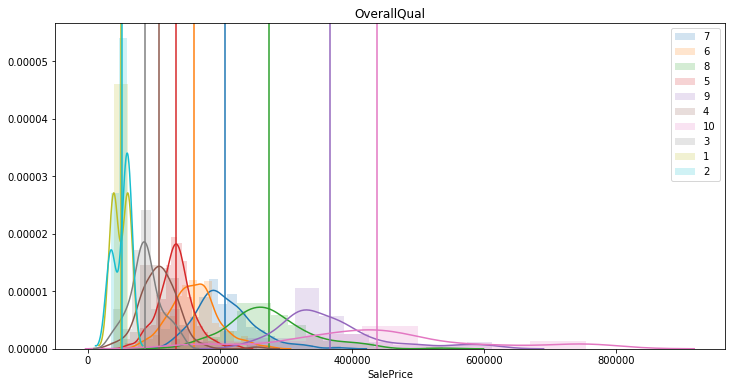

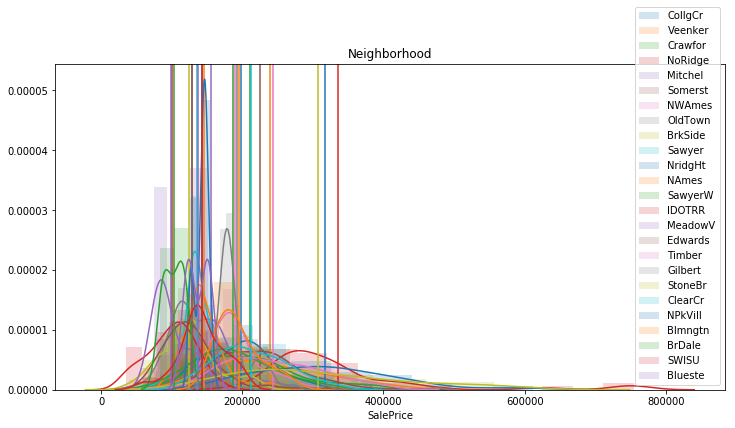

ANOVA says means are *not* equal


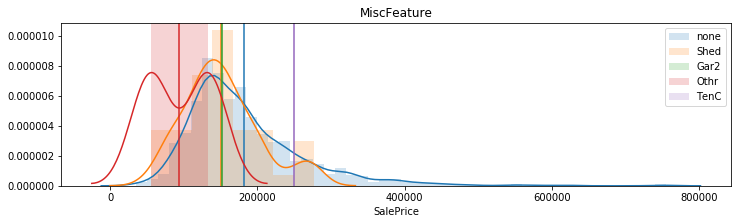

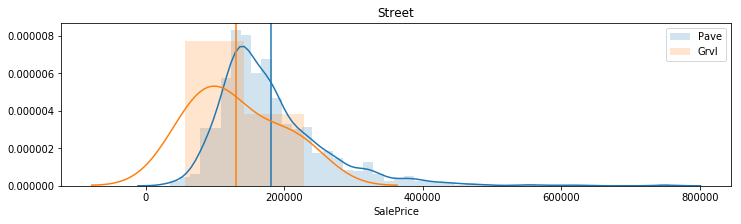

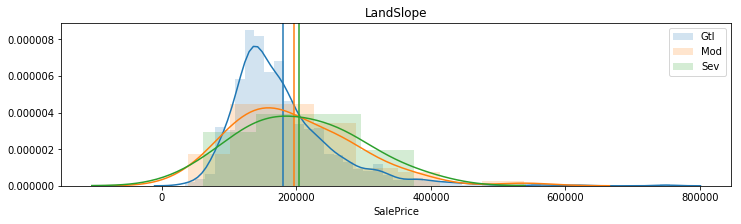

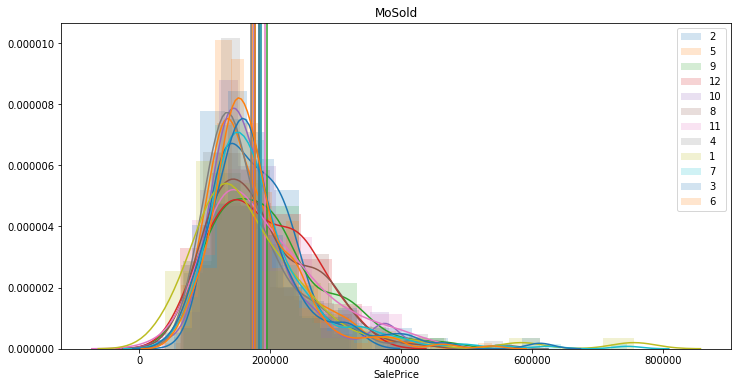

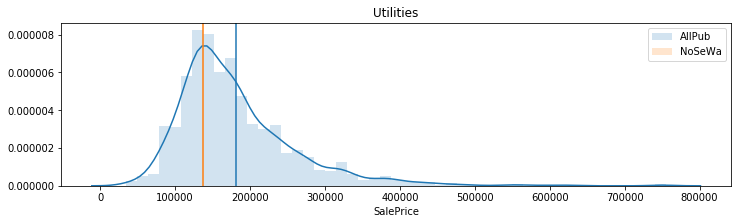

In [5]:
def my_anova(feature):
    feat_s = train_df[feature]
    sq_within = []
    
    for val in feat_s.unique():
        val_s = train_df.SalePrice[feat_s == val]
        sq_within_grp = (val_s - val_s.mean())**2
        sq_within = sq_within + list(sq_within_grp)
    
    SSW = np.sum(sq_within)
    
    sq_btwn = []; mean_total = train_df.SalePrice.mean()
    for val in feat_s.unique():
        sq_btwn_grp = (train_df.SalePrice[feat_s == val].mean() 
                       - mean_total)**2
        sq_btwn_grp = sq_btwn_grp * train_df.SalePrice[feat_s == val].shape[0]
        sq_btwn.append(sq_btwn_grp)
    
    SSB = np.sum(sq_btwn)    
    
    n = feat_s.shape[0]; m = len(feat_s.unique())
    df_W = (n-m)
    df_B = m-1
    
    mean_sq_btwn = SSB/df_B
    mean_sq_within = SSW/df_W
    
    F = mean_sq_btwn/mean_sq_within
    p = stats.f.sf(F, df_B, df_W)
    return F, p

pp = []
for f in cat_df:
    _, p = my_anova(f)
    pp.append(p)

pp = pd.concat([pd.Series(cat_df.columns.values),
                pd.Series(pp)], axis = 'columns')
pp.columns = ['feat', 'pvalue']

pp['ordered'] = pp.pvalue.rank(method = 'dense')

def anova_top(n_feats):
    return pp.sort_values(by = 'pvalue')[0:n_feats]

def anova_bottom(n_feats):
    not_null = pp.sort_values(by = 'pvalue').pvalue.isnull() == False
    return pp.sort_values(by = 'pvalue')[not_null][-n_feats:]

def get_handle_color_drop_alpha(handle):
    matplotlib_color_is_tuple = handle.get_facecolor()
    lists_are_mutable = list(matplotlib_color_is_tuple)
    col_drop_alpha = tuple(lists_are_mutable[:3])
    return col_drop_alpha

def chart_dist_cats(categories):
    for category in categories:
        ylims = list()
        
        values = train_df[category].unique()
        if len(values) > 6:
            scatter_plt = plt.figure(figsize = (12,6))
        else:
            scatter_plt = plt.figure(figsize = (12, 3))
    
        for val in values:
            price_df = train_df.SalePrice
            filter_for = train_df[category]
            prices_in_cat = price_df[filter_for == val]
            
            n_obs = len(prices_in_cat)
            no_houses_sold = n_obs == 0
            if no_houses_sold:
                pass
            
            else:
                distplot_needs_more_than_1_obs = n_obs == 1
                if distplot_needs_more_than_1_obs:
                    prices_in_cat = prices_in_cat.append(prices_in_cat)
                    
                scatter_ax = sns.distplot(prices_in_cat, 
                                         norm_hist=True,
                                         kde=True,
                                         hist_kws = {'alpha': 0.2},
                                         label = str(val))
                
                handles, _ = scatter_ax.get_legend_handles_labels()
                val_handle = handles[-1]
                val_color = get_handle_color_drop_alpha(val_handle)
                plt.axvline(prices_in_cat.mean(), color = val_color)
                
                this_ylim = scatter_ax.get_ylim()[1]
                ylims.append(this_ylim)
                if this_ylim > 1:
                    ylims.remove(this_ylim)
                    scatter_ax.set_ylim(top = max(ylims))

        plt.title(category)
        plt.legend()
        plt.show()
print('ANOVA says means are equal')
chart_dist_cats(anova_top(2).feat.values)
print('ANOVA says means are *not* equal')
chart_dist_cats(anova_bottom(5).feat.values)

In [6]:
anova_bottom(5).feat.tolist()

['MiscFeature', 'Street', 'LandSlope', 'MoSold', 'Utilities']

In [7]:
anova_drop = anova_bottom(5).feat.tolist()
to_drop = to_drop + anova_drop

### Dropping Highly Correlated Features
These highly correlated features are not surprising. The size of a garage, `GarageArea`, would mean that it could fit more cars, so `GarageCars` is higher. The most obvious next step is to drop one of those two features and repeat with the following highly correlated pairs. 
However, we can use our domain knowledge, knowledge of housing, to hypothesize that perhaps we can drop all features describing floor space and replace it with another summarizing feature `TotLivArea`. We are only limiting ourselves to ten features.

In [8]:
## features where its correlation with another feature is greater than 0.5, not counting its correlation with itself which is 1
is_num = train_df.dtypes.isin([np.dtype('float64'), np.dtype('int64')])
num_feats = train_df.dtypes.index[is_num]
num_df = train_df[num_feats]

high_corr_count = num_df.corr()[num_df.corr() > 0.5][num_df.corr() < 1].count().sort_values(ascending = False)
high_corr_count = high_corr_count[high_corr_count>0]
high_corr_count

SalePrice       7
GarageCars      3
YearBuilt       3
TotalBsmtSF     3
1stFlrSF        3
GrLivArea       3
GarageArea      2
YearRemodAdd    2
BsmtFinSF1      2
BsmtFullBath    1
2ndFlrSF        1
dtype: int64

In [9]:
high_corr_feats = high_corr_count.index.values

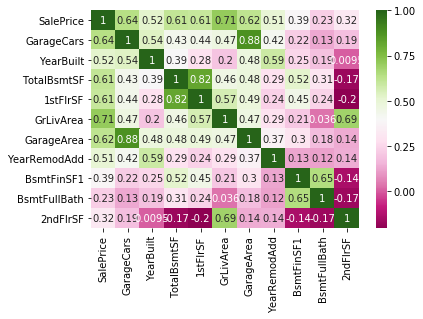

In [10]:
sns.heatmap(train_df[high_corr_feats].corr(), annot = True, cmap = plt.get_cmap('PiYG'))

#### Replacing Highly Correlated Features About Floor Space With Stronger Feature
`GrLivArea` is highly correlated with `SalePrice`. Total living area which is the total basement area plus the ground living area is more correlated with `SalePrice`. Let's create a new column for total living area and drop the other features describing ground space.

In [11]:
sf = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
      '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
      'GarageArea', 'PoolArea', 'LotArea', 'OpenPorchSF',
      'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'WoodDeckSF']

train_df[sf + ['SalePrice']].corr()['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
GrLivArea        0.711767
GarageArea       0.623464
TotalBsmtSF      0.614971
1stFlrSF         0.605720
BsmtFinSF1       0.386148
WoodDeckSF       0.325971
2ndFlrSF         0.323717
OpenPorchSF      0.318868
LotArea          0.264927
BsmtUnfSF        0.212509
ScreenPorch      0.113165
PoolArea         0.092934
ThreeSsnPorch    0.045055
BsmtFinSF2      -0.013482
LowQualFinSF    -0.025396
EnclosedPorch   -0.128566
Name: SalePrice, dtype: float64

##### Pairplot 
The pairplot further underscores that there is a linear relationship between these features. The diagonal shows histograms. `TotLivArea` is also better because it has a more normal distribution than the features that I'm removing.

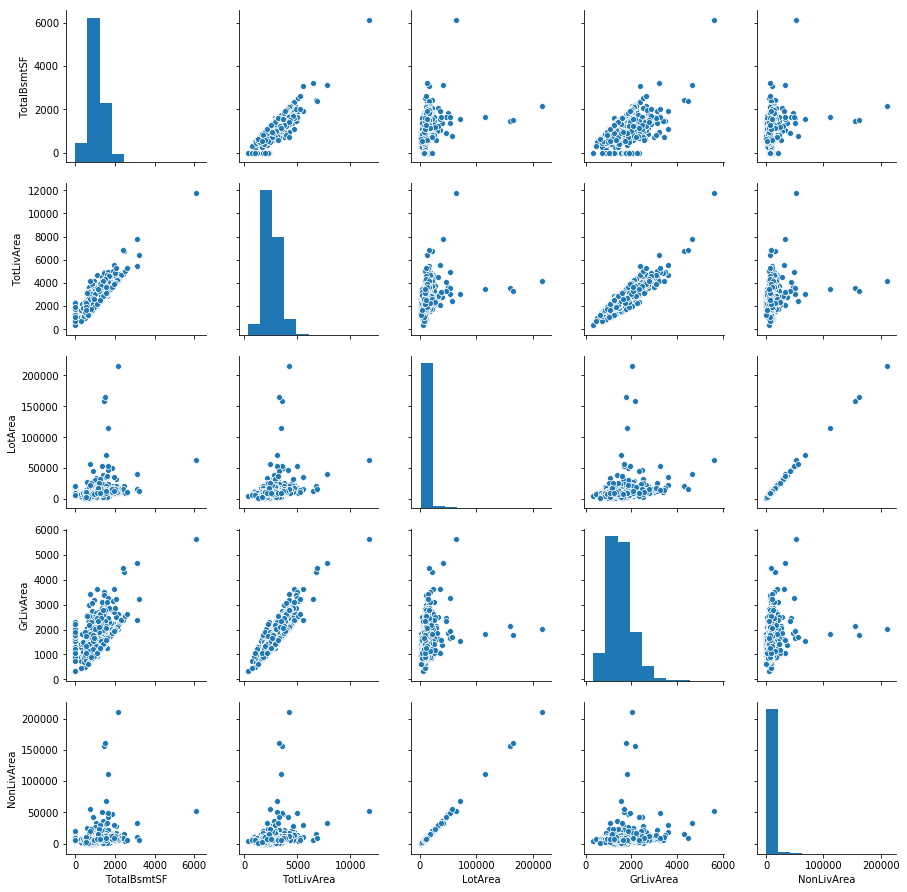

In [12]:
train_df['TotLivArea'] = train_df.GrLivArea + train_df.TotalBsmtSF
train_df['NonLivArea'] = train_df.LotArea - train_df.TotLivArea

summ_sf = ['TotalBsmtSF', 'TotLivArea', 'LotArea', 'GrLivArea', 'NonLivArea']
sns.pairplot(train_df[summ_sf])

SalePrice       8
TotLivArea      6
TotalBsmtSF     4
1stFlrSF        4
GrLivArea       4
GarageCars      4
YearBuilt       3
GarageArea      3
YearRemodAdd    2
BsmtFinSF1      2
NonLivArea      1
LotArea         1
2ndFlrSF        1
BsmtFullBath    1
dtype: int64

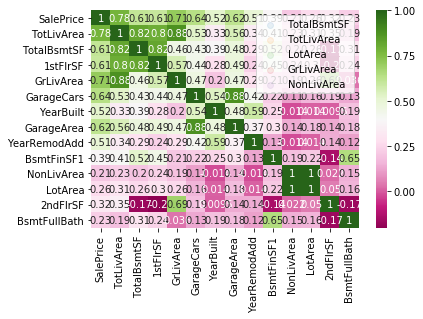

In [13]:
def plot_regs(features):
    for f in features:
        sns.regplot(x = train_df[f],
                    label =  f,
                    scatter_kws = {'alpha': 0.1},
                    y = train_df.SalePrice)
    plt.legend()

plot_regs(summ_sf)

to_drop = to_drop + ['TotalBsmtSF','LotArea', 'GrLivArea', 'NonLivArea']

## features where its correlation with another feature is greater than 0.5, not counting its correlation with itself which is 1
is_dtype_num = train_df.dtypes.isin([np.dtype('float64'), np.dtype('int64')])
num_feats = train_df.dtypes.index[is_dtype_num]
num_df = train_df[num_feats]
high_corr_count = num_df.corr()[num_df.corr() > 0.5][num_df.corr() < 1].count().sort_values(ascending = False)
high_corr_count = high_corr_count[high_corr_count>0]
display(high_corr_count)
high_corr_feats = high_corr_count.index.values

sns.heatmap(train_df[high_corr_feats].corr(), annot = True, cmap = plt.get_cmap('PiYG'))

to_drop = to_drop + ['GarageCars', '1stFlrSF']

In [14]:
XY = train_df.drop(columns = to_drop)
X = XY.drop(columns = ['SalePrice'])
y = XY.SalePrice

In [15]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch',
       'PoolArea', 'PoolQC', 'Fen